### Libraries

In [1]:
# Libraries 

import numpy as np
from numpy import array
from numpy import hstack
from numpy.random import default_rng
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
import torch.optim as optim  # Import optim module
#from random import random.seed,gauss
from sklearn.preprocessing import MinMaxScaler, StandardScaler


### Parameters 

In [46]:
##
## Parameters
##

# time step
dt=0.025
# units of time to warm up NVAR. need to have warmup_pts >= 1
warmup = 5.
# units of time to train for
traintime = 10.
# units of time to test for
testtime=120.
# total time to run for
maxtime = warmup+traintime+testtime
# how much of testtime to plot
plottime=20.
# Lyapunov time of the Lorenz system
lyaptime=1.104

# discrete-time versions of the times defined above
warmup_pts=round(warmup/dt)
traintime_pts=round(traintime/dt)
warmtrain_pts=warmup_pts+traintime_pts
testtime_pts=round(testtime/dt)
maxtime_pts=round(maxtime/dt)
plottime_pts=round(plottime/dt)
lyaptime_pts=round(lyaptime/dt)

# input dimension
d = 3
# number of time delay taps
k = 2
# size of linear part of feature vector
dlin = k*d
# size of nonlinear part of feature vector
dnonlin = int(dlin*(dlin+1)/2)
# total size of feature vector: constant + linear + nonlinear
dtot = 1 + dlin + dnonlin

# ridge parameter for regression
ridge_param = 1.4e-2

# t values for whole evaluation time
# (need maxtime_pts + 1 to ensure a step of dt)
t_eval=np.linspace(0,maxtime,maxtime_pts+1)

# generate Gaussian random numbers at step dt and then interpolate for integrator
rng = np.random.default_rng(seed=1)

# width of the Gaussian distribution
width=1.

xran=rng.normal(0.,width,maxtime_pts+1)
yran=rng.normal(0.,width,maxtime_pts+1)
zran=rng.normal(0.,width,maxtime_pts+1)
xran_i = interp1d(t_eval,xran)
yran_i = interp1d(t_eval,yran)
zran_i = interp1d(t_eval,zran)

lorenz_soln_nf=np.zeros((d,maxtime_pts+1))

### Lorenz 63

In [47]:
sigma = 10
beta = 8 / 3
rho = 28

def lorenz(t, y):

  dy0 = sigma * (y[1] - y[0])
  dy1 = y[0] * (rho - y[2]) - y[1]
  dy2 = y[0] * y[1] - beta * y[2]

  # since lorenz is 3-dimensional, dy/dt should be an array of 3 values
  return [dy0, dy1, dy2]


### Solution of Lorenz 63


In [48]:

# I integrated out to t=50 to find points on the attractor, then use these as the initial conditions

lorenz_soln = solve_ivp(lorenz, (0, maxtime), [17.67715816276679, 12.931379185960404, 43.91404334248268] , t_eval=t_eval, method='RK23')

# total variance of Lorenz solution
total_var=np.var(lorenz_soln.y[0:d,:])

### Split the Sequence 

[[17.67715816 15.77695495 12.83202575  9.49915688  6.31667148]
 [12.93137919  5.68211629 -0.14898817 -3.81814923 -5.64699747]
 [43.91404334 44.85194679 42.87695699 39.54693535 36.08397169]
 [ 0.         17.67715816 15.77695495 12.83202575  9.49915688]
 [ 0.         12.93137919  5.68211629 -0.14898817 -3.81814923]
 [ 0.         43.91404334 44.85194679 42.87695699 39.54693535]]


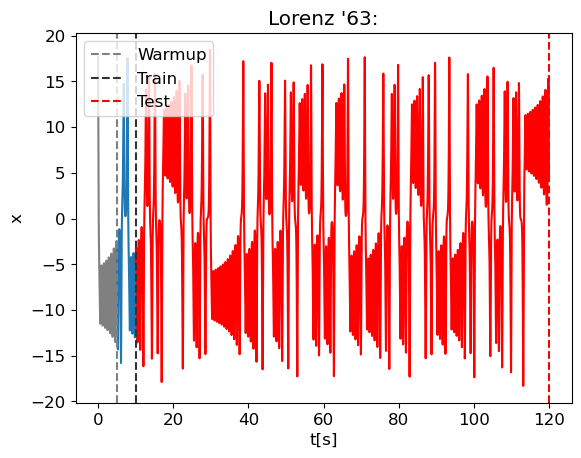

In [49]:
# create an array to hold the linear part of the feature vector
x = np.zeros((dlin,maxtime_pts))

# fill in the linear part of the feature vector for all times
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]

#scaler = StandardScaler()
#x = scaler.fit_transform(x)


print(x[:,0:5])
plt.plot(t_eval[0:warmup_pts+1],x[0,0:warmup_pts+1],"0.5")
plt.plot(t_eval[warmup_pts:traintime_pts+1],x[0,warmup_pts:traintime_pts+1])
plt.plot(t_eval[traintime_pts:testtime_pts],x[0,traintime_pts:testtime_pts], "r")
plt.axvline(x=warmup_pts*dt, ls='--', color='0.5', label='Warmup')
plt.axvline(x=traintime_pts*dt, ls='--', color='0.2', label='Train')
plt.axvline(x=testtime_pts*dt, ls='--', color='r', label='Test')
plt.legend(loc='upper left')

plt.title("Lorenz '63:")
plt.xlabel("t[s]")
plt.ylabel("x")
plt.show()


### Parameters for LSTM 

In [231]:
input_size = dlin
sequence_length = 20

num_layers=2
hidden_size=10

learning_rate = 0.001

output_dim = 3
batch_size = 1
num_epochs = 20

### Define LSTM 

In [232]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, :])
        return out

In [233]:
model = LSTMModel(input_size, hidden_size, num_layers, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
x_tensor = torch.tensor(x, dtype=torch.float32)#.reshape(-1, sequence_length, input_size)
x_tensor.to(device)
loss_criterion  = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#x_tensor = x_tensor.reshape(-1,input_size, sequence_length)
#x_tensor.shape
print(x_tensor, x_tensor.shape)
#x_out = torch.zeros(x_tensor.shape).reshape(3,-1)
#x_out.shape

tensor([[17.6772, 15.7770, 12.8320,  ...,  6.8122,  5.2747,  4.0096],
        [12.9314,  5.6821, -0.1490,  ...,  0.1655, -0.3458, -0.4914],
        [43.9140, 44.8519, 42.8770,  ..., 32.4331, 30.3239, 28.3193],
        [ 0.0000, 17.6772, 15.7770,  ...,  8.5689,  6.8122,  5.2747],
        [ 0.0000, 12.9314,  5.6821,  ...,  1.2430,  0.1655, -0.3458],
        [ 0.0000, 43.9140, 44.8519,  ..., 34.5379, 32.4331, 30.3239]]) torch.Size([6, 5400])


### Normalizing 

In [234]:
scaler = StandardScaler().fit(x_tensor)
x_tensor_n = scaler.transform(x_tensor)
x_tensor_n = x_tensor.clone().detach()
#x_tensor_n = torch.tensor(x_tensor, dtype=torch.float32)

### Training the Model 

At epoch: 0, loss: 2.4173855559632647
At epoch: 10, loss: 0.225806274710485


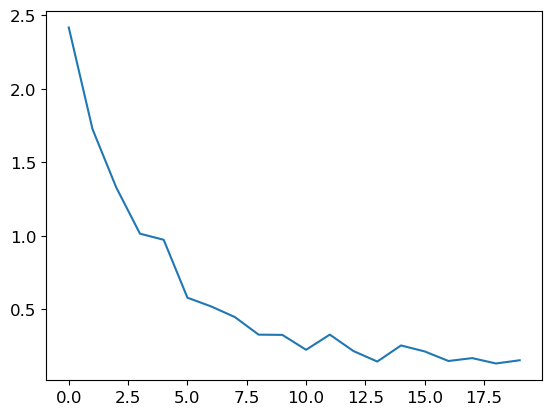

In [235]:
current_loss = 0
loss_hist = []
loss = 0
model.train()

for epoch in range(num_epochs):
    for i in range(traintime_pts - 1):
        index = i + warmup_pts -1
        target = x_tensor_n[0:d,index+sequence_length]-x_tensor_n[d:dlin,index+sequence_length]
        data = x_tensor_n[:,index:index+sequence_length]
        data = data.to(device)
        data = torch.transpose(data, 0, 1)
        target = target.to(device)
        outputs = model(data)
        loss = loss_criterion(outputs[sequence_length-1,:],target)
        current_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch % 10 == 0):
        print(f"At epoch: {epoch}, loss: {current_loss/traintime_pts}")
    loss_hist.append(current_loss/traintime_pts)
    current_loss = 0

plt.plot(loss_hist)
plt.show()

# calculate NRMSE between true Lorenz and training output
#rms = np.sqrt(np.mean((x[0:d,warmup_pts:warmtrain_pts]-x_predict[:,:])**2)/total_var)
#print('training nrmse: '+str(rms))

### Testing

In [236]:
def evaluate():
    model.eval()
    total_acc, total_count = 0, 0
    predicted = torch.zeros(dlin,testtime_pts).to(device)
    predicted[:,0:sequence_length+1] = x_tensor_n[:,warmtrain_pts:warmtrain_pts+sequence_length+1]
    with torch.no_grad():
        for i in range(testtime_pts-sequence_length-1):
          xin = predicted[:,i:i+sequence_length]
          output = model(torch.transpose(xin, 0, 1))
          predicted[d:dlin,i+sequence_length+1] = predicted[0:d,i+sequence_length]
          predicted[0:d,i+sequence_length+1] = output[sequence_length-1,:] + predicted[d:dlin,i+sequence_length+1]
          #loss = loss_criterion(predicted[:,i], x_tensor[:,testtime_pts+i])
          total_acc += loss
          #total_count += label.size(0)
    return predicted

xin = torch.zeros(dlin,sequence_length).to(device)
pred = evaluate()

MSE = loss_criterion(x_tensor_n[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu(), pred[0:d,0:lyaptime_pts].cpu())

print(MSE)

#MSE = loss_criterion(x_tensor[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu(), torch.tensor(x_test[0:d,0:lyaptime_pts]))

#print(MSE)

# calculate MSE between true Lorenz and prediction for one Lyapunov time
#test_nrmse = np.sqrt(np.mean((x_tensor[0:d,warmtrain_pts-1:warmtrain_pts+lyaptime_pts-1].cpu().detach().numpy()-pred[0:d,0:lyaptime_pts].cpu().detach().numpy()**2)/total_var))
#print('test nrmse: '+str(test_nrmse))

tensor(10.7233)


In [237]:
#print(d)
print(pred)
plot_pred = np.reshape(pred, [3, -1])
print(plot_pred)
print(plot_pred.shape)
#print(outputs[sequence_length-1,:])

tensor([[ 8.3803, 10.0800, 11.9036,  ...,  0.8128,  1.0146,  1.1196],
        [14.7734, 17.2008, 19.2269,  ...,  2.7599,  2.7643,  2.7754],
        [14.4574, 17.1122, 20.8885,  ..., 24.8342, 23.7911, 22.7764],
        [ 6.8942,  8.3803, 10.0800,  ...,  0.5192,  0.8128,  1.0146],
        [12.3653, 14.7734, 17.2008,  ...,  2.7463,  2.7599,  2.7643],
        [12.7697, 14.4574, 17.1122,  ..., 25.9148, 24.8342, 23.7911]])
tensor([[ 8.3803, 10.0800, 11.9036,  ...,  2.7599,  2.7643,  2.7754],
        [14.4574, 17.1122, 20.8885,  ...,  0.5192,  0.8128,  1.0146],
        [12.3653, 14.7734, 17.2008,  ..., 25.9148, 24.8342, 23.7911]])
torch.Size([3, 9600])


### Plot

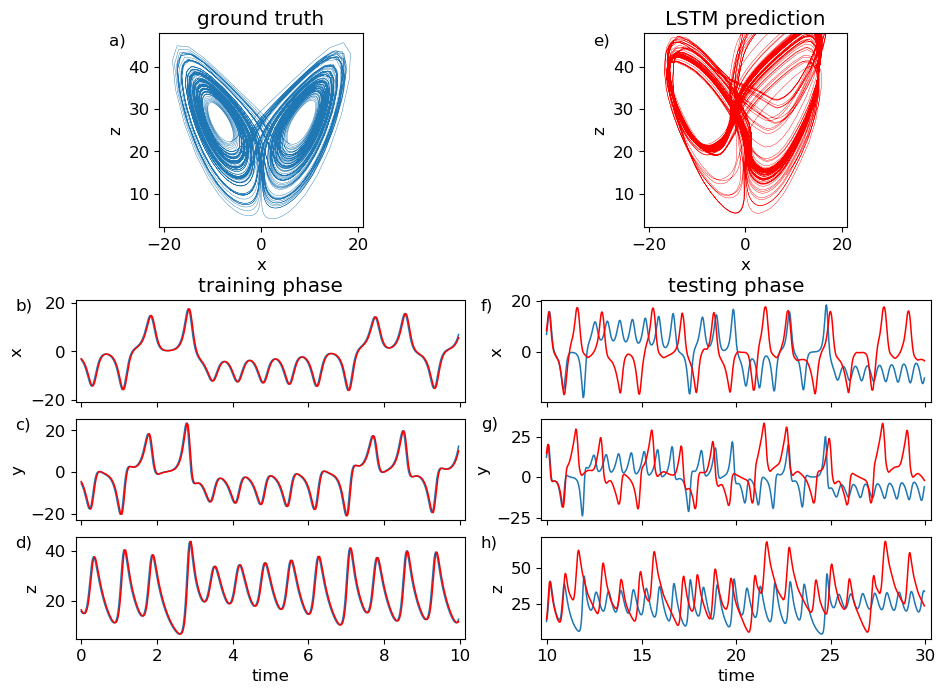

In [238]:

##
## Plot
##

# create an array to hold the linear part of the feature vector
x = np.zeros((dlin,maxtime_pts))

# fill in the linear part of the feature vector for all times
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=lorenz_soln.y[:,j-delay]
        
x_predict = x[0:d,warmup_pts-1:warmtrain_pts-1]


t_linewidth=1.1
a_linewidth=0.3
plt.rcParams.update({'font.size': 12})

fig1 = plt.figure()
fig1.set_figheight(8)
fig1.set_figwidth(12)

xlabel=[10,15,20,25,30]
h=120
w=100

# top left of grid is 0,0
axs1 = plt.subplot2grid(shape=(h,w), loc=(0, 9), colspan=22, rowspan=38)
axs2 = plt.subplot2grid(shape=(h,w), loc=(52, 0), colspan=42, rowspan=20)
axs3 = plt.subplot2grid(shape=(h,w), loc=(75, 0), colspan=42, rowspan=20)
axs4 = plt.subplot2grid(shape=(h,w), loc=(98, 0), colspan=42, rowspan=20)
axs5 = plt.subplot2grid(shape=(h,w), loc=(0, 61), colspan=22, rowspan=38)
axs6 = plt.subplot2grid(shape=(h,w), loc=(52, 50),colspan=42, rowspan=20)
axs7 = plt.subplot2grid(shape=(h,w), loc=(75, 50), colspan=42, rowspan=20)
axs8 = plt.subplot2grid(shape=(h,w), loc=(98, 50), colspan=42, rowspan=20)

# true Lorenz attractor
axs1.plot(x[0,warmtrain_pts:maxtime_pts],x[2,warmtrain_pts:maxtime_pts],linewidth=a_linewidth)
axs1.set_xlabel('x')
axs1.set_ylabel('z')
axs1.set_title('ground truth')
axs1.text(-.25,.92,'a)', ha='left', va='bottom',transform=axs1.transAxes)
axs1.axes.set_xbound(-21,21)
axs1.axes.set_ybound(2,48)

# training phase x
axs2.set_title('training phase')
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[0,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs2.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[0,:],linewidth=t_linewidth, color='r')
axs2.set_ylabel('x')
axs2.text(-.155,0.87,'b)', ha='left', va='bottom',transform=axs2.transAxes)
axs2.axes.xaxis.set_ticklabels([])
axs2.axes.set_ybound(-21.,21.)
axs2.axes.set_xbound(-.15,10.15)

# training phase y
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[1,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs3.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[1,:],linewidth=t_linewidth,color='r')
axs3.set_ylabel('y')
axs3.text(-.155,0.87,'c)', ha='left', va='bottom',transform=axs3.transAxes)
axs3.axes.xaxis.set_ticklabels([])
axs3.axes.set_xbound(-.15,10.15)

# training phase z
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x[2,warmup_pts:warmtrain_pts],linewidth=t_linewidth)
axs4.plot(t_eval[warmup_pts:warmtrain_pts]-warmup,x_predict[2,:],linewidth=t_linewidth,color='r')
axs4.set_ylabel('z')
axs4.text(-.155,0.87,'d)', ha='left', va='bottom',transform=axs4.transAxes)
axs4.set_xlabel('time')
axs4.axes.set_xbound(-.15,10.15)

# prediction attractor
axs5.plot(pred[0,:].cpu(), pred[2,:].cpu(),linewidth=a_linewidth,color='r')
axs5.set_xlabel('x')
axs5.set_ylabel('z')
axs5.set_title('LSTM prediction')
axs5.text(-.25,0.92,'e)', ha='left', va='bottom',transform=axs5.transAxes)
axs5.axes.set_xbound(-21,21)
axs5.axes.set_ybound(2,48)

# testing phase x
axs6.set_title('testing phase')
axs6.set_xticks(xlabel)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[0,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs6.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,pred[0,0:plottime_pts],linewidth=t_linewidth,color='r')
axs6.set_ylabel('x')
axs6.text(-.155,0.87,'f)', ha='left', va='bottom',transform=axs6.transAxes)
axs6.axes.xaxis.set_ticklabels([])
axs6.axes.set_xbound(9.7,30.3)

# testing phase y
axs7.set_xticks(xlabel)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[1,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs7.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,pred[1,0:plottime_pts],linewidth=t_linewidth,color='r')
axs7.set_ylabel('y')
axs7.text(-.155,0.87,'g)', ha='left', va='bottom',transform=axs7.transAxes)
axs7.axes.xaxis.set_ticklabels([])
axs7.axes.set_xbound(9.7,30.3)

# testing phase z
axs8.set_xticks(xlabel)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,x[2,warmtrain_pts-1:warmtrain_pts+plottime_pts-1],linewidth=t_linewidth)
axs8.plot(t_eval[warmtrain_pts-1:warmtrain_pts+plottime_pts-1]-warmup,pred[2,0:plottime_pts],linewidth=t_linewidth,color='r')
axs8.set_ylabel('z')
axs8.text(-.155,0.87,'h)', ha='left', va='bottom',transform=axs8.transAxes)
axs8.set_xlabel('time')
axs8.axes.set_xbound(9.7,30.3)